# Video pipeline with Yolo + Resnet Model

In [21]:
import pandas as pd
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser

In [22]:
series = 64

series_path = os.path.join(FINAL_RESULTS_PATH, "series", str(series))

loader = AdaptationParser(
    series_path=series_path, model_name="video", type_of="pipeline"
)

In [23]:
configs = loader.load_configs()
for config_name, config in configs.items():
    print(f"File name: {config_name}")
    pp.pprint(config)
accuracy_method = config["accuracy_method"]
adaptation_interval = config["adaptation_interval"]
simulation_mode = config["simulation_mode"]

File name: 6.yaml
{   'accuracy_method': 'sum',
    'adaptation_interval': 20,
    'allocation_mode': 'base',
    'alpha': 0,
    'baseline_mode': 'scale',
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': True,
    'distrpution_time': 10,
    'gamma': 0,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'metadata': 'repeat of 61 with debug mode to see the results',
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 10,
    'nodes': [   {   'cpu_request': '2',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
                     'memory_request': '2Gi',
                     'model_variants': 'yolov5n',
                     'node_name': 'yolo',
                     'num_interop_threads': '1',
  

In [24]:
# load the sent workload
workload_type = config["workload_type"]
workload_config = config["workload_config"][0]
start = workload_config["start"]
end = workload_config["end"]
damping_factor = workload_config["damping_factor"]
sent_workload = twitter_workload_generator(
    days=f"{start}-{end}", damping_factor=damping_factor
)

In [25]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
if not simulation_mode:
    results = loader.result_processing()

In [26]:
adaptation_log = loader.load_adaptation_log()

In [27]:
series_changes = loader.series_changes(
    adaptation_log=adaptation_log
)  # TODO go inside this

## Comparing Predicted Load with the Recieved Load

[5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25, 24, 25, 24, 23, 25, 24, 25, 23, 30, 28, 26, 25, 26, 27, 27, 27, 28, 30, 25, 26, 29, 26, 26, 29, 27, 29, 29, 28, 29, 26, 26, 24, 27, 28, 26, 29, 28, 29, 26, 26, 32, 24, 26, 26, 26, 26, 24, 25, 28, 27, 29, 26, 26, 26, 31, 30, 26, 29, 33, 29, 28, 29, 28, 30, 28, 29, 29, 26, 25, 27, 28, 27, 25]
[5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25, 24, 25, 24, 23, 25, 24, 25, 23, 30, 28, 26, 25, 26, 27, 27, 27, 28, 30, 25, 26, 29, 26, 26, 29, 27, 29, 29, 28, 29, 26, 26, 24, 27, 28, 26, 29, 28, 29, 26, 26, 32, 24, 26, 26, 26, 26, 24, 25, 28, 27, 29, 

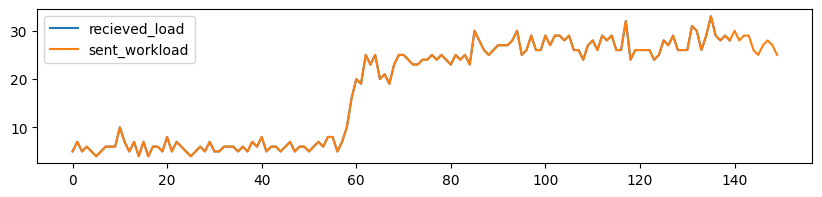

In [28]:
recieved_load = series_changes["recieved_load"]
# recieved_load = [int(item) for item in recieved_load if item != 0]
recieved_load_x = [x for x in range(0, len(recieved_load))]
sent_load_x = [x for x in range(0, len(sent_workload))]
print(sent_workload)
print(recieved_load)

print(len(sent_workload))
print(len(recieved_load))
plt.figure(figsize=(10, 2))
plt.plot(recieved_load_x, recieved_load, label="recieved_load")
plt.plot(sent_load_x, sent_workload, label="sent_workload")
# TODO add predicted reference load here
plt.legend()
plt.show()

In [29]:
def draw_dicts(dict_to_draw: Dict[str, List[int]], adaptation_interval=None):
    num_keys = len(dict_to_draw.keys())
    fig, axs = plt.subplots(nrows=num_keys, ncols=1, figsize=(10, num_keys * 2))
    x_values = range(len(list(dict_to_draw.values())[0]))
    if adaptation_interval is not None:
        x_values = [item * adaptation_interval for item in list(x_values)]
    if num_keys > 1:
        for i, key in enumerate(dict_to_draw.keys()):
            axs[i].plot(x_values, dict_to_draw[key], label=key)
            axs[i].set_title(key)
            axs[i].legend()
    else:
        key = list(dict_to_draw.keys())[0]
        axs.plot(x_values, dict_to_draw[key], label=key)
        axs.set_title(key)
        axs.legend()

    plt.tight_layout()
    plt.show()

## Replica Changes
1. Total
2. Per node

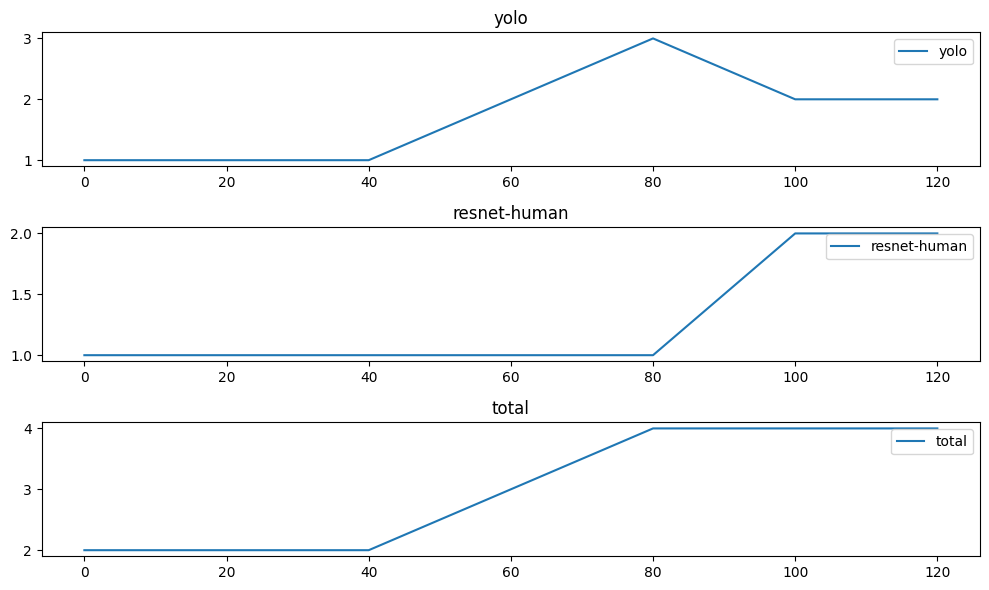

In [30]:
replica_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    replica_changes[node_name] = metrics["replicas"]
    nodes.append(node_name)
# replica_changes['total'] = []
replica_changes["total"] = [sum(x) for x in zip(*replica_changes.values())]
draw_dicts(replica_changes, adaptation_interval)

## Per Container Core changes
1. Total
2. Per Node

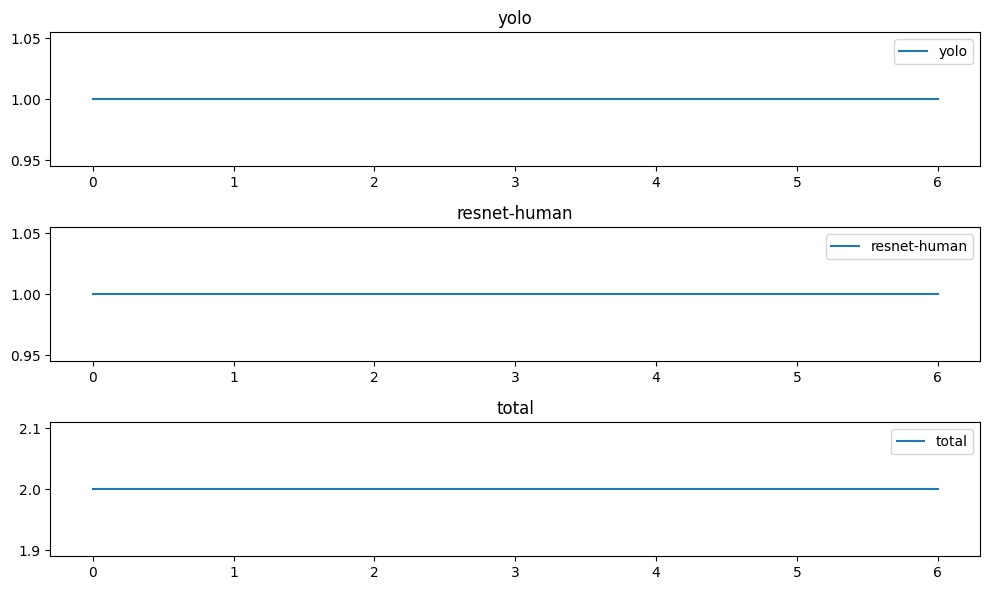

In [31]:
core_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    core_changes[node_name] = metrics["cpu"]
    nodes.append(node_name)
core_changes["total"] = [sum(x) for x in zip(*core_changes.values())]
draw_dicts(core_changes)

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

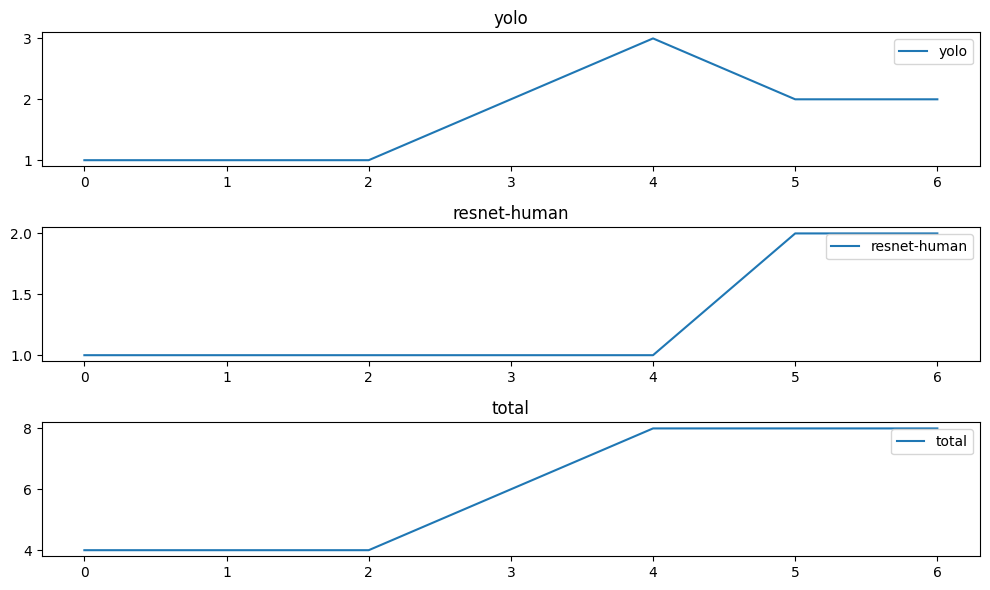

In [32]:
total_core_changes = {}
for key in replica_changes.keys():
    total_core_changes[key] = [
        x * y for x, y in zip(replica_changes[key], core_changes[key])
    ]
draw_dicts(total_core_changes)

## Accuracy Changes

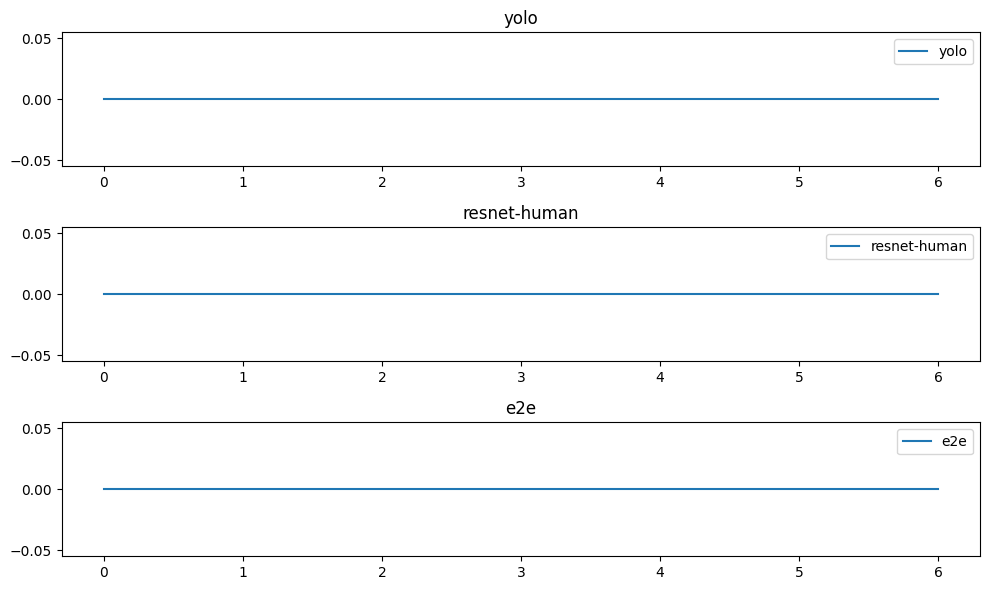

In [33]:
accuracy_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    accuracy_changes[node_name] = metrics["accuracy"]
    nodes.append(node_name)
# replica_changes['total'] = []
if accuracy_method == "sum":
    accuracy_changes["e2e"] = [sum(x) for x in zip(*accuracy_changes.values())]
draw_dicts(accuracy_changes)

## Batching Changes

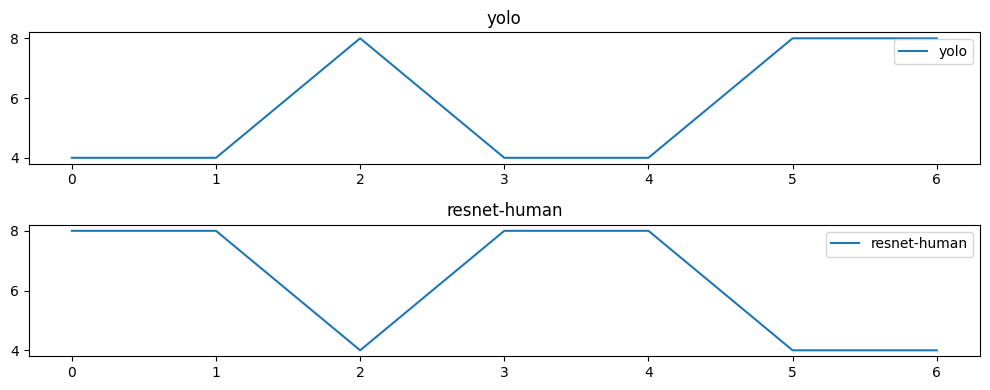

In [34]:
batching_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    batching_changes[node_name] = metrics["batch"]
    nodes.append(node_name)
# replica_changes['total'] = []
# batching_changes['total'] = [sum(x) for x in zip(*batching_changes.values())]
draw_dicts(batching_changes)

# Expected Throughput

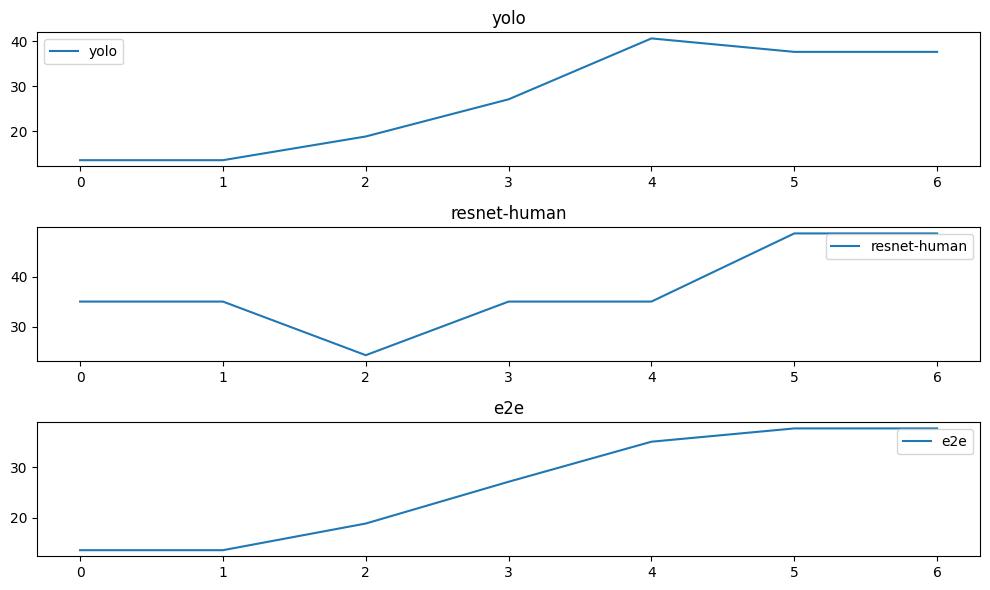

In [35]:
throughput_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    throughput_changes[node_name] = metrics["throughput"]
    nodes.append(node_name)
# replica_changes['total'] = []
throughput_changes["e2e"] = [min(x) for x in zip(*throughput_changes.values())]
draw_dicts(throughput_changes)

## Expected Latency

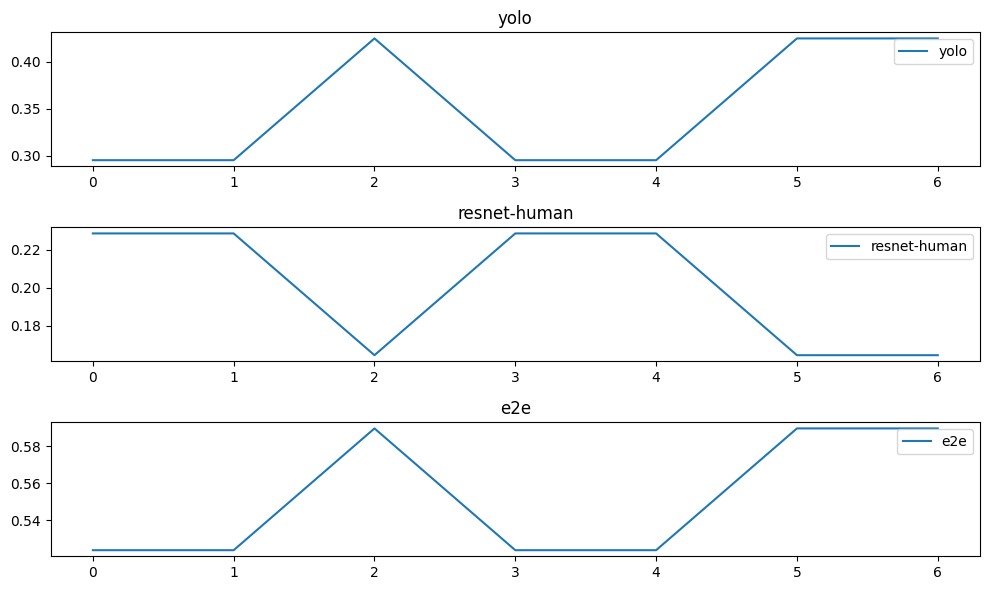

In [36]:
latency_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    latency_changes[node_name] = metrics["latency"]
    nodes.append(node_name)
# replica_changes['total'] = []
latency_changes["e2e"] = [sum(x) for x in zip(*latency_changes.values())]
draw_dicts(latency_changes)

# Real Latencies

## Maeseured p99 Latency


In [38]:
if not simulation_mode:
    timeout_per_second, per_second_results = loader.per_second_result_processing()

In [39]:
if not simulation_mode:
    p99_cols = list(filter(lambda col: "min" in col, per_second_results.columns))
    p99_all = per_second_results[p99_cols]  # [1400:]
    p99_all["p99_e2e"] = p99_all.sum(axis=1).to_list()
    draw_dicts(p99_all.to_dict(orient="list"))

# Every point a change was triggered

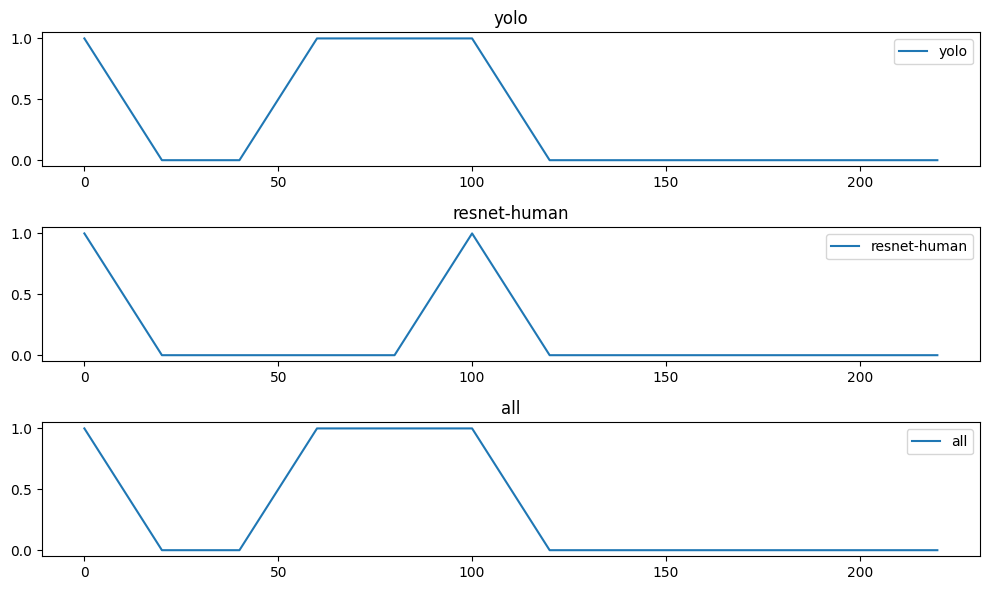

In [ ]:
series_changes.keys()
change_trigger = loader.points_with_change(adaptation_log=adaptation_log)
change_trigger["all"] = [any(x) for x in zip(*change_trigger.values())]
draw_dicts(change_trigger, adaptation_interval=adaptation_interval)

# Changes in the objective

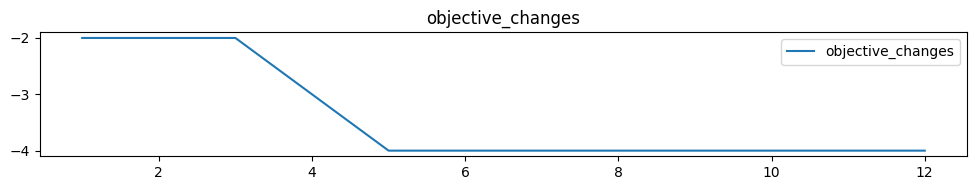

In [ ]:
objective_changes = series_changes["objective"]
objective_changes = {"objective_changes": objective_changes}
draw_dicts(objective_changes)

## Config Change

In [ ]:
# TODO sent load -> extract the sent date from twitter trace and also from the recived load on the server
# TODO model ranks/accuracies -> 1. load accuracy scores 2. start with Mehran but go rank based
# TODO model CPU usgages
# TODO SLA violations
# TODO

In [40]:
if not simulation_mode:
    timeout_dics = {"timeout_per_second": timeout_per_second}
    draw_dicts(timeout_dics)
    print(f"{sum(timeout_per_second)} out of {sum(sent_workload)}")

[5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25, 24, 25, 24, 23, 25, 24, 25, 23, 30, 28, 26, 25, 26, 27, 27, 27, 28, 30, 25, 26, 29, 26, 26, 29, 27, 29, 29, 28, 29, 26, 26, 24, 27, 28, 26, 29, 28, 29, 26, 26, 32, 24, 26, 26, 26, 26, 24, 25, 28, 27, 29, 26, 26, 26, 31, 30, 26, 29, 33, 29, 28, 29, 28, 30, 28, 29, 29, 26, 25, 27, 28, 27, 25]
[5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25, 24, 25, 24, 23, 25, 24, 25, 23, 30, 28, 26, 25, 26, 27, 27, 27, 28, 30, 25, 26, 29, 26, 26, 29, 27, 29, 29, 28, 29, 26, 26, 24, 27, 28, 26, 29, 28, 29, 26, 26, 32, 24, 26, 26, 26, 26, 24, 25, 28, 27, 29, 

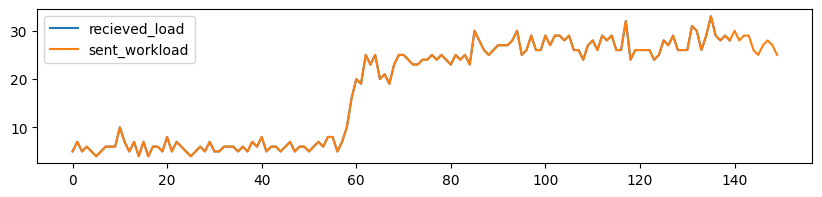

In [41]:
recieved_load = series_changes["recieved_load"]
# recieved_load = [int(item) for item in recieved_load if item != 0]
recieved_load_x = [x for x in range(0, len(recieved_load))]
sent_load_x = [x for x in range(0, len(sent_workload))]
print(sent_workload)
print(recieved_load)

print(len(sent_workload))
print(len(recieved_load))
plt.figure(figsize=(10, 2))
plt.plot(recieved_load_x, recieved_load, label="recieved_load")
plt.plot(sent_load_x, sent_workload, label="sent_workload")
plt.legend()
plt.show()

In [42]:
for key, value in series_changes.items():
    if key == "nodes":
        for node_name, all_configs in value.items():
            print(f"node: {node_name}\n")
            for config_name, config_values in all_configs.items():
                print(f"{config_name}: {config_values}")

node: yolo

cpu: [1, 1, 1, 1, 1, 1, 1]
replicas: [1, 1, 1, 2, 3, 2, 2]
batch: [4, 4, 8, 4, 4, 8, 8]
variant: ['yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n']
latency: [0.2952772217317099, 0.2952772217317099, 0.4249932919204991, 0.2952772217317099, 0.2952772217317099, 0.4249932919204991, 0.4249932919204991]
accuracy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
throughput: [13.546591831707278, 13.546591831707278, 18.823826521705456, 27.093183663414557, 40.63977549512184, 37.64765304341091, 37.64765304341091]
node: resnet-human

cpu: [1, 1, 1, 1, 1, 1, 1]
replicas: [1, 1, 1, 1, 1, 2, 2]
batch: [8, 8, 4, 8, 8, 4, 4]
variant: ['resnet18', 'resnet18', 'resnet18', 'resnet18', 'resnet18', 'resnet18', 'resnet18']
latency: [0.22845245956797547, 0.22845245956797547, 0.16452856011495448, 0.22845245956797547, 0.22845245956797547, 0.16452856011495448, 0.16452856011495448]
accuracy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
throughput: [35.018226615413695, 35.018226615413695, 24.311888